# Compare Data and Simulated spectra
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : June 20th 2017




In [6]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
print theNotebook

AnaCompareDataSimSpec


In [8]:
from matplotlib.backends.backend_pdf import PdfPages

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [10]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [11]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [12]:
%load_ext Cython

In [13]:
from IPython.display import Image, display

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [15]:
from scipy.interpolate import interp1d

In [16]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [17]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [18]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [19]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')

In [20]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [21]:
%config InlineBackend.rc = {}
matplotlib.rc_file("../../templates/matplotlibrc")

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [22]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [23]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [24]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### Output directory for images generated in the notebook view (not true fits images)¶¶

In [25]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [26]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [27]:
inputdir="./spectrum_calibspec"
MIN_IMGNUMBER=60
MAX_IMGNUMBER=160
object_name='HD205905 Jun 01th 2017'
object_name_sim='HD205905_June_01th'
SelectTagRe='^calibSpectra_20170601_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^calibSpectra_20170601_[0-9]+.fits$'
NBIMGPERROW=2

In [28]:
!ls

AllSimSpectra_HD205905_June_01th.fits
AnaCompareDataSimSpec.ipynb
AnaEqWdtCalibSpectrum.ipynb
CalibrateSpectrum.ipynb
Extract_Spectrum.ipynb
FindCentralStar.ipynb
FindCentralStarFast.ipynb
FindOptRot.ipynb
GenerateSimulationProfiles.ipynb
MakeLogBook.ipynb
ReduceAllImages.ipynb
ViewAllImages.ipynb
cut_fitsimages
images_notebooks
logbk_HD205905_June_01th_ctio01jun2017.csv
logbk_HD205905_June_01th_ctio01jun2017.fits
processed_fitsimages
randomseed
reduced_fitsimages
rotated_fitsimages
simulations
spectrum_calibspec
spectrum_fitsspec


In [29]:
inputsimfitsfile='AllSimSpectra_'+object_name_sim+'.fits'

### Output Fits file

In [30]:
outputdir="./spectrum_compdatasim"

In [31]:
ensure_dir(outputdir)

In [32]:
output_file='AnaCompDataSimSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

### Simulated spectra

In [33]:
hdu_list=fits.open(inputsimfitsfile)
header=hdu_list[0].header
print header
simspectra_data=hdu_list[0].data

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 4839                                                  NAXIS2  =                  102                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [34]:
print simspectra_data.shape

(102, 4839)


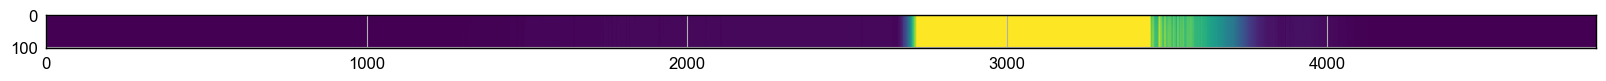

In [35]:
plt.figure(figsize=(20,20))
plt.imshow(simspectra_data[:,:],vmin=0,vmax=1e-12)
plt.xmin=(0.,10000.)

### Data

In [36]:
input_filelist=os.listdir(inputdir) 

In [37]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [38]:
print input_filelist[0:5]

['calibSpectra_20170601_060.fits' 'calibSpectra_20170601_061.fits'
 'calibSpectra_20170601_062.fits' 'calibSpectra_20170601_063.fits'
 'calibSpectra_20170601_064.fits']


In [39]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [40]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file 
            
            if re.search('.*fits$',filename):  #example of filename filter
                
                num_str=re.findall(SelectTagRe,file)[0]
               
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)   
                
                
    return indexes_files, filelist_fitsimages

In [41]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [42]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [43]:
print indexes_files

[ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160]


In [44]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [45]:
sorted_numbers=indexes_files[sorted_indexes]

In [46]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


In [47]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [48]:
sorted_files[0:5]

array(['./spectrum_calibspec/calibSpectra_20170601_060.fits',
       './spectrum_calibspec/calibSpectra_20170601_061.fits',
       './spectrum_calibspec/calibSpectra_20170601_062.fits',
       './spectrum_calibspec/calibSpectra_20170601_063.fits',
       './spectrum_calibspec/calibSpectra_20170601_064.fits'], 
      dtype='|S51')

## Build full filename
----------------------------

In [49]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [50]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [51]:
print sorted_filenames.shape

(101,)


## Acces to spectrum data
----------------------------------

In [52]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        filters = header['FILTERS'].split(' ')[1]
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpec')
       
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpec')
       
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
       
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        
        all_filt.append(filters)
            
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo, all_leftspectra_data,all_rightspectra_data, all_leftspectra_wl,all_rightspectra_wl,        all_filt

In [53]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_wl,all_rightspectra_wl,all_filt=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [54]:
print len(all_dates)

101


In [55]:
print all_filt

['HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'H

In [56]:
Thor300_index=np.where(np.array(all_filt) == 'Thor300')[0]
Ron400_index=np.where(np.array(all_filt) == 'Ron400')[0]
HoloPhP_index=np.where(np.array(all_filt) == 'HoloPhP')[0]
HoloPhAg_index=np.where(np.array(all_filt) == 'HoloPhAg')[0]
HoloAmAg_index=np.where(np.array(all_filt) == 'HoloAmAg')[0]

In [57]:
print Thor300_index
print Ron400_index
print HoloPhP_index
print HoloPhAg_index
print HoloAmAg_index

[ 3  8 13 18 23 28 33 38 43 48 53 58 63 68 73 78 83 88 93 98]
[ 2  7 12 17 22 27 32 37 42 47 52 57 62 67 72 77 82 87 92 97]
[ 4  9 14 19 24 29 34 39 44 49 54 59 64 69 74 79 84 89 94 99]
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]
[ 1  6 11 16 21 26 31 36 41 46 51 56 61 66 71 76 81 86 91 96]


## Airmass

In [58]:
NDATA=len(all_rightspectra_data)
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


LookupError: unknown encoding: macroman

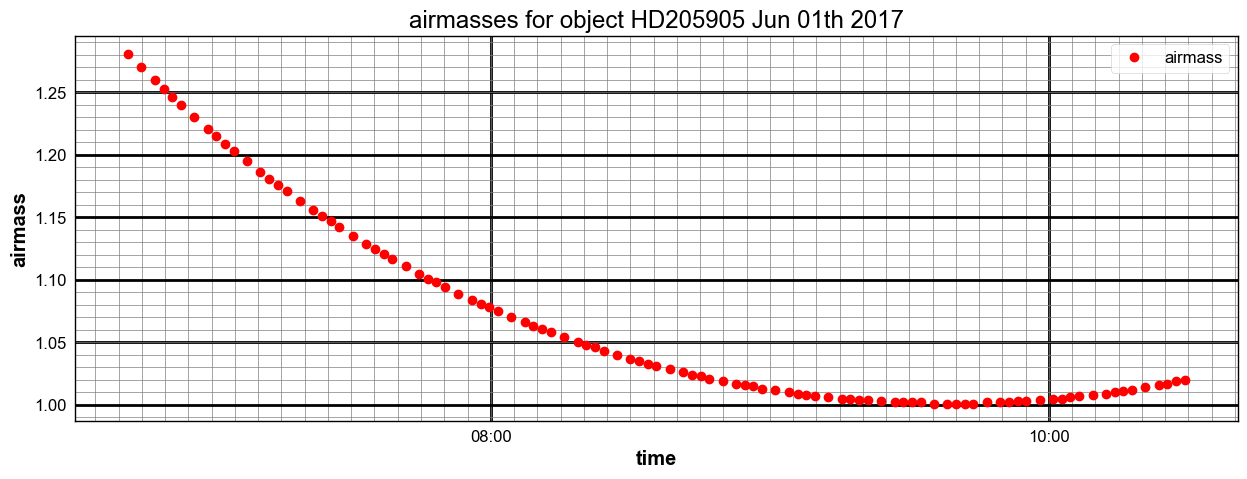

In [59]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_airmass,marker='o',color='red',lw=0,label='airmass',linewidth=3)
#ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

#ax.set_ylim(0.,2)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='grey', linewidth=0.5)
ax.set_ylabel('airmass')
ax.set_xlabel('time')


title='airmasses for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

figfilename=os.path.join(dir_top_images,'airmass_vs_time.pdf')
fig.savefig(figfilename)

## Show Spectra
==========================

In [60]:
NDATA=len(all_rightspectra_data)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


In [61]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math as m
import os

from matplotlib.backends.backend_pdf import PdfPages
 
NormSpecRange= [790,810] # range where to normalize


def ShowSpectra(all_spectra,all_wl,all_titles,object_name,all_filt,dir_top_img,sim_data):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBSPEC=len(all_spectra)
    NBIMGPERROW=2
    MAXIMGROW=max(2,m.ceil(NBSPEC/NBIMGPERROW))
    #MAXIMGROW=int(MAXIMGROW)
        

    calibdatasimfactor = []    
        
        
     # fig file specif
    NBIMGROWPERPAGE=5  # number of rows per pages
    PageNum=0          # page counter
    
    figfilename=os.path.join(dir_top_img,'intput_calibrated_spectra.pdf')
    pp = PdfPages(figfilename) # create a pdf file
    
    title='Calibrated spectra for {}'.format(object_name)
         
    thex0 = []  # container of central position   
    wl_sim=sim_data[0]/10.
    
    for index in np.arange(0,NBSPEC):
        if index%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,size=20,fontweight='bold')
 


  


        indexcut=index-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
        ix=indexcut%NBIMGPERROW
        iy=indexcut/NBIMGPERROW
        
        wl=all_wl[index]  # wavelength in data
        
        spectrum=all_spectra[index]   # data
        
        maxdata_in_range=np.max(spectrum[np.where(np.logical_and(wl>NormSpecRange[0],wl<NormSpecRange[1]))]) # max in data in selected wl range
        
        
        spectrum_sim=sim_data[index+1] # sim
        maxsim_in_range=np.max(spectrum_sim[np.where(np.logical_and(wl_sim>NormSpecRange[0],wl_sim<NormSpecRange[1]))]) # max in sim in selected wl range
        
        calibfactor=maxdata_in_range/maxsim_in_range   # calib factor data/sim in wl range
        
        calibdatasimfactor.append(calibfactor) # for later analysis
        
       
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data') # plot data
        
        
        spectrum_sim=spectrum_sim*calibfactor  # renormalize the sim to data units
        
        axarr[iy,ix].plot(wl_sim,spectrum_sim,'b-',lw=2,label='sim')
        
        max_y_to_plot=spectrum[:].max()*1.4
        axarr[iy,ix].set_ylim(0.,max_y_to_plot)
        axarr[iy,ix].set_xlim(0.,1200.)
        axarr[iy,ix].text(0.,max_y_to_plot*1.1/1.4, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
       
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_title(all_filt[index])
        axarr[iy,ix].set_xlabel("wavelength (nm)")
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='grey', linewidth=0.5)
      
        axarr[iy,ix].legend()
        
        # save a new page
        if (index+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            PageNum+=1  # increase page Number
            f.savefig(pp, format='pdf')
            f.show()
            
                
          
    
    f.savefig(pp, format='pdf') 
    f.show()
    pp.close()
    return np.array(calibdatasimfactor)
    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/inspect.py", line 1049, in getinnerframes
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/dagoret-campagnesylvie/anaconda/env

IndexError: string index out of range

### Work only on right spectra

In [ ]:
all_calibdatasimfactors=ShowSpectra(all_rightspectra_data,all_rightspectra_wl,all_titles,object_name,all_filt,dir_top_images,simspectra_data)

In [ ]:
all_calibdatasimfactors=np.array(all_calibdatasimfactors)

In [ ]:
Thor300_factor=all_calibdatasimfactors[Thor300_index]
Ron400_factor=all_calibdatasimfactors[Ron400_index]
HoloPhP_factor=all_calibdatasimfactors[HoloPhP_index]
HoloPhAg_factor=all_calibdatasimfactors[HoloPhAg_index]
HoloAmAg_factor=all_calibdatasimfactors[HoloAmAg_index]


In [ ]:
Thor300_factor_av=np.median(Thor300_factor)
Ron400_factor_av=np.median(Ron400_factor)
HoloPhP_factor_av=np.median(HoloPhP_factor)
HoloPhAg_factor_av=np.median(HoloPhAg_factor)
HoloAmAg_factor_av=np.median(HoloAmAg_factor)

In [ ]:
figfilename=os.path.join(dir_top_images,'calib_factor.pdf')

plt.figure(figsize=(15,8))

plt.plot(Thor300_index,Thor300_factor,marker='o',color='green',label='Thor300')
plt.plot([0,Thor300_index.max()],[Thor300_factor_av,Thor300_factor_av],'g-')

plt.plot(Ron400_index,Ron400_factor,marker='o',color='grey',label='Ron400')
plt.plot([0,Ron400_index.max()],[Ron400_factor_av,Ron400_factor_av],'-',color='grey')

plt.plot(HoloPhP_index,HoloPhP_factor,marker='o',color='red',label='HoloPhP')
plt.plot([0,HoloPhP_index.max()],[HoloPhP_factor_av,HoloPhP_factor_av],'r-')


plt.plot(HoloPhAg_index,HoloPhAg_factor,marker='o',color='blue',label='HoloPhAg')
plt.plot([0,HoloPhAg_index.max()],[HoloPhAg_factor_av,HoloPhAg_factor_av],'b-')

plt.plot(HoloAmAg_index,HoloAmAg_factor,marker='o',color='black',label='HoloAmAg')
plt.plot([0,HoloAmAg_index.max()],[HoloAmAg_factor_av,HoloAmAg_factor_av],'k-')


plt.grid(True)
plt.legend(loc='best')
plt.title('Calibration factor data/sim')
plt.xlabel("Event rank")
plt.ylabel("factor")
plt.savefig(figfilename) 

In [ ]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

In [ ]:
sel=0
thespectrum=all_rightspectra_data[sel]

In [ ]:
def ShowOneSpectrum(sel):
    """
    ShowOneSpectrum
    ================
    """


    thespectrum=all_rightspectra_data[sel]
    thewl=all_rightspectra_wl[sel]
    ymin=thespectrum.min()
    ymax=thespectrum.max()*1.1
    
    
    wl_sim=simspectra_data[0]/10.
    
    sim_spec=simspectra_data[sel+1]*all_calibdatasimfactors[sel]

    fig, ax = plt.subplots(1, 1, figsize=(15,8))


    ax.plot(thewl,thespectrum,'r-',lw=2,label='data')
    ax.plot(wl_sim,sim_spec,'b-',lw=2,label='sim')

    max_y_to_plot=thespectrum[:].max()*1.4
    ax.set_ylim(0.,max_y_to_plot)
    ax.text(0.,max_y_to_plot*1.1/1.4, all_filt[sel],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)

    ax.set_title(all_titles[sel])
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='grey', linewidth=0.5)

    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{\\alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{\\beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{\\gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{\\delta}$',lw=1)
    ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{\\epsilon}$',lw=1)

    ax.legend(loc='best',fontsize=20)
    ax.set_xlim(0,1100)
    ax.set_xlabel("$\lambda$ (nm)")
    
    figname='one_intput_calibrated_spectra_{}.pdf'.format(sel)
    
    figfilename=os.path.join(dir_top_images,figname)
    fig.savefig(figfilename)

In [ ]:
ShowOneSpectrum(1)

In [ ]:
ShowOneSpectrum(2)

In [ ]:
ShowOneSpectrum(3)

In [ ]:
ShowOneSpectrum(4)

In [ ]:
ShowOneSpectrum(5)

In [ ]:
def ShowOneSpectrumNextFilt(sel):
    """
    ShowOneSpectrum
    ================
    """

    NBSPECTOPLOT=5
    
    the_spectra= []
    the_wl=[]
    the_max = []
    the_label= []
    
    for i in np.arange(NBSPECTOPLOT):

        the_spectrum=all_rightspectra_data[sel+i]
        thewl=all_rightspectra_wl[sel+i]
        theymin=the_spectrum.min()
        theymax=the_spectrum.max()
        thelabel=all_filt[sel+i]
        
        the_spectra.append(the_spectrum)
        the_wl.append(thewl)
        the_max.append(theymax)
        the_label.append(thelabel)

        
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    for i in np.arange(NBSPECTOPLOT):        
        ax.plot(the_wl[i],the_spectra[i],lw=3,label=the_label[i])

 
        
    max_y_to_plot=(np.array(the_max)).max()
    ymin=0
    ymax=max_y_to_plot
    ax.set_ylim(0.,max_y_to_plot)
    
    ax.set_title(all_titles[sel])
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='grey', linewidth=0.5)

    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b:',label='$O_2(A)$',lw=3)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b:',label='$O_2(B)$',lw=3)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r:',label='$H_{\\alpha}$',lw=3)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g:',label='$H_{\\beta}$',lw=3)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c:',label='$H_{\\gamma}$',lw=3)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k:',label='$H_{\\delta}$',lw=3)
    ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y:',label='$H_{\\epsilon}$',lw=3)

    ax.legend(loc='best',fontsize=20)
    ax.set_xlim(0,1100)
    ax.set_xlabel("$\lambda$ (nm)")
    
    
    figname='five_intput_calibrated_spectra_{}.pdf'.format(sel)
    figfilename=os.path.join(dir_top_images,figname)
    fig.savefig(figfilename)

In [ ]:
ShowOneSpectrumNextFilt(1)